Pseudotime Trajectory Inference
===============================


[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AllenWLynch/MIRA/HEAD?labpath=docs%2Fsource%2Fnotebooks%2Ftutorial_mira.time.ipynb)

**^ Binder launches an interactive session of this tutorial with the environment pre-configured!**

MIRA's pseudotime facilities infer pseudotime and parse lineage trees from 
the joint k-nearest neighbors graph of multiome data.
First, MIRA applies an adaptation of the Palantir algorithm to calculate diffusion
pseudotime and terminal state probabilities for each cell. Then, MIRA applies
a new lineage tree inference algorithm to reconstruct bicurcating tree
structure of differentation data.

In this tutorial, we will use pseudotime trajectory inference to investigate
the lineage structure of the hair follicle.

First, import packages and the data:

In [1]:
import mira
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=550, frameon = False, legend_fontsize=12
)

mira.datasets.PseudotimeTrajectoryInferenceTutorial()

data = anndata.read_h5ad('mira-datasets/shareseq.hair_follicle.joint_representation.h5ad')
mira.utils.pretty_sderr()

INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/shareseq.hair_follicle.joint_representation.h5ad


Taking a look at the UMAP, we see that starting from the **ORS**, cells progress through the **Matrix**, branching into the **IRS**, then the **Cortex** and **Medulla**.

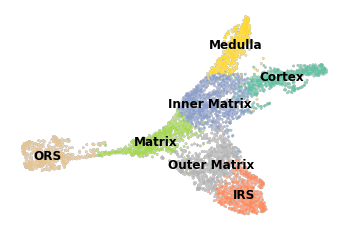

In [2]:
sc.pl.umap(data, color = 'true_cell', palette='Set2', legend_loc='on data', title = '', **umap_kwargs)

## Defining pseudotime

The first step in identifying the lineage structure of this data is to compute a diffusion map of the underlying nearest neighbors graph. ``sc.tl.diffmap`` will use the KNN graph in ``data.obsp["connectivities"]`` to compute a diffusion map representation of the data. In this case, the connectivities are derived from the Joint KNN graph, so the diffusion map will represent cells in a bimodal space.

First, calculate the diffusion map, then use [mira.time.normalize_diffmap](../time/mira.time.normalize_diffmap.html) to rescale the components of the diffusion map. This regularizes distortions in magnitude of the eigenvectors.

In [3]:
sc.tl.diffmap(data)
mira.time.normalize_diffmap(data)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 5 diffusion map components.


Next, we need to choose the best number of diffusion components to represent the data. Too few components will not capture the full structure of the data, too many will overfit and induce strange structures. Below, we use [mira.pl.plot_eigengap](../time/mira.pl.plot_eigengap.html) to plot the "Eigengap" heuristic, which is the difference in magnitude of successive sorted eigenvalues. 


**The component with the highest Eigengap is an estimate of the best number of components to represent the data**, but may not capture all relevent structure. For this reason, we also plot the diffusion components projected over the UMAP, with which we can check how many components are needed to capture differences between cell types.

In the case of the hair follicle, Eigengap recommends using 5 diffusion components, which appears to adequately describe differences bewteen cell types.

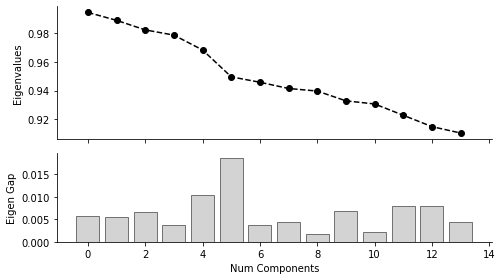

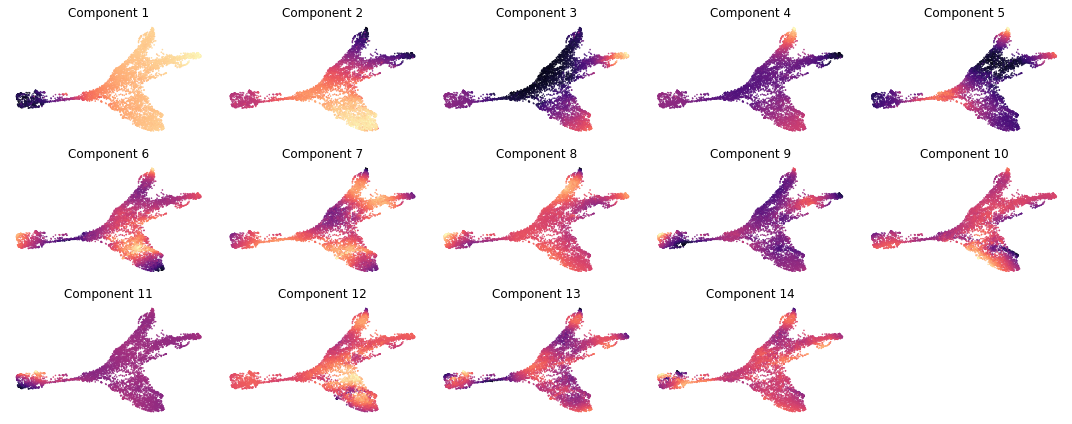

In [4]:
mira.pl.plot_eigengap(data, palette='magma')
plt.show()

Next, we must define a new nearest-neighbors graph based on the diffusion components. For `sc.pp.neighbors`, we indicate that we wish to calculate a new KNN graph using the first 5 components from `data.obsm["X_diffmap"]`.

**It is critical that you subset how many components to use before calculating nearest neighbors on the diffusion map**.

In [5]:
import numpy as np
np.random.seed(0)
data = data[data.obs_names[np.random.permutation(5000)]] # subset data to 5000 cells to sneak under binder 2GB memory limit

In [6]:
data.obsm['X_diffmap'] = data.obsm['X_diffmap'][:,:5] # subset the number of dimensions
sc.pp.neighbors(data, use_rep='X_diffmap', key_added='X_diffmap')

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Then, we check to make sure there are no disconnected component graphs in the data using [mira.time.get_connected_components](../time/mira.time.get_connected_components.html). The remainder of the methods only work on connected graphs, and will raise an error if they are run on cells spanning multiple disconnected components.

In [7]:
mira.time.get_connected_components(data)

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


Now, we can assign cells a pseudotime and define a transport map describing a markov chain model of forward differentiation using [mira.time.get_transport_map](../time/mira.time.get_transport_map.html). This function requires we define a start cell, which must be chosen using knowledge of the system. Usually, the cell which is the minima or maxima of the first diffusion component works well as a start point. In this case, we use the minima:

In [8]:
mira.time.get_transport_map(data, start_cell= int(data.obsm['X_diffmap'][:,0].argmin()))

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.


Calculating pseudotime:   0%|          | 0/56650 [00:00<?, ?it/s]

INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


This function calculates the transport map and assigns cells a pseudotime based on their shortest-path distance from the start cell:

... storing 'mira_connected_components' as categorical


<AxesSubplot:title={'center':'mira_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

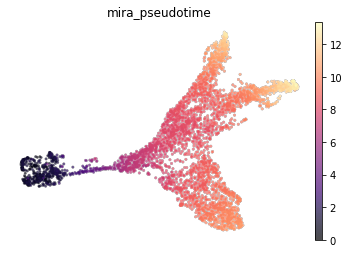

In [9]:
sc.pl.umap(data, color = 'mira_pseudotime', show = False,
           **umap_kwargs, color_map = 'magma')

## Lineage inference

From the transport map, we may find terminal states where the markov chain reaches a steady state. [mira.time.find_terminal_cells](../time/mira.time.find_terminal_cells.html) outputs cells that appear to be at the termini of lineages. Increase the `iterations` parameter, or increase the `treshold` parameter (e.g. 1e-3 to 1e-2) to find more terminal cell candidates. Be sure to set the seed for repeatable results.

INFO:mira.pseudotime.pseudotime:Found 3 terminal states from stationary distribution.


Terminal cells:  R1.18.R2.43.R3.02.P1.55, R1.23.R2.87.R3.61.P1.53, R1.64.R2.61.R3.40.P1.56


INFO:mira.pseudotime.pseudotime:Found 11 terminal states from stationary distribution.


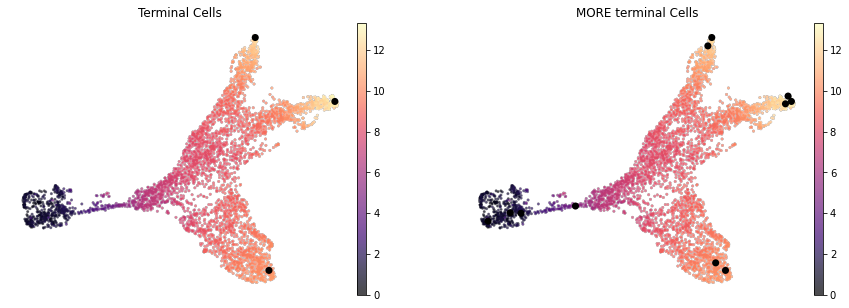

In [10]:
terminal_cells = mira.time.find_terminal_cells(data, seed = 3)
print('Terminal cells: ', ', '.join(terminal_cells))
MORE_terminal_cells = mira.time.find_terminal_cells(data, seed = 3, iterations = 10, threshold=1e-2)

fig, ax = plt.subplots(1,2,figsize=(15,5))
sc.pl.umap(data, color = 'mira_pseudotime', show = False,
           **umap_kwargs, color_map = 'magma', ax = ax[0])
sc.pl.umap(data[terminal_cells], na_color = 'black', ax = ax[0], 
          size = 200, title = 'Terminal Cells', show=False)

sc.pl.umap(data, color = 'mira_pseudotime', show = False,
           **umap_kwargs, color_map = 'magma', ax = ax[1])
sc.pl.umap(data[MORE_terminal_cells], na_color = 'black', ax = ax[1], 
           size = 200, title = 'MORE terminal Cells')

Next, we use [mira.time.get_branch_probabilities](../time/mira.time.get_branch_probabilities.html) to find the probability of reaching each terminal state from each cell in the markov chain. To this function, we provide a dictionary with lineage names as keys, and values as terminal cell barcodes.

In [11]:
mira.time.get_branch_probabilities(data, terminal_cells= {
    'Medulla' : terminal_cells[1],
    'Cortex' : terminal_cells[0],
    'IRS' : terminal_cells[2]
})

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Medulla_prob
INFO:mira.adata_interface.core:Added cols to obs: Cortex_prob
INFO:mira.adata_interface.core:Added cols to obs: IRS_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


Outputs from this function include the probabilities of reaching each terminal state, and differentiation entropy.

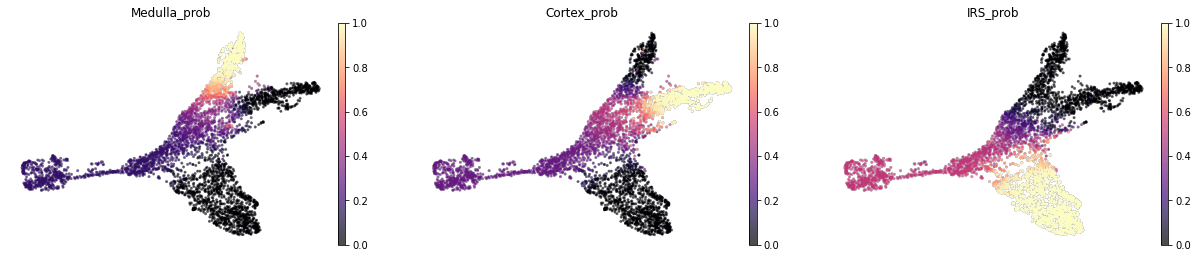

In [12]:
sc.pl.umap(data,
   color = [x + '_prob' for x in data.uns['lineage_names']], 
   color_map='magma', **umap_kwargs)

Finally, we can parse the lineage probabilities to find the bifurcating tree structure of the data. The [mira.time.get_tree_structure](../time/mira.time.get_tree_structure.html) function takes the `threshold` parameter, which controls how sensitive the algorithm is to branch divergences. 

Specifically, `threshold` controls the how great the log2-ratio of differentiating down one branch compared to another must be to declare a branch point. To place branch points when the probability of traveling down the **Medulla** branch is 1.5 times greater than the **Cortex** branch, set threshold to 0.58 (this appears to work as a good default):

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
... storing 'tree_states' as categorical


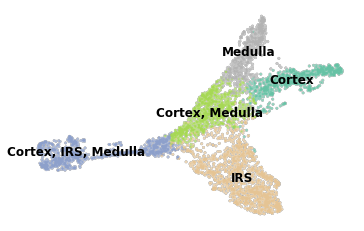

In [13]:
mira.time.get_tree_structure(data, threshold = 0.58)
sc.pl.umap(data, color = 'tree_states', palette = 'Set2', 
           **umap_kwargs, title = '', legend_loc='on data')

## Visualizing lineages and topics

Finally, with the tree structure solved, we can visualize expression dynamics using streamgraphs. For more information on making informative visualizations using this flexible interface, read the [streamgraph docs](../plotting/mira.pl.plot_stream.html) and check out the [streamgraph tutorial](tutorial_streamgraphs.html).

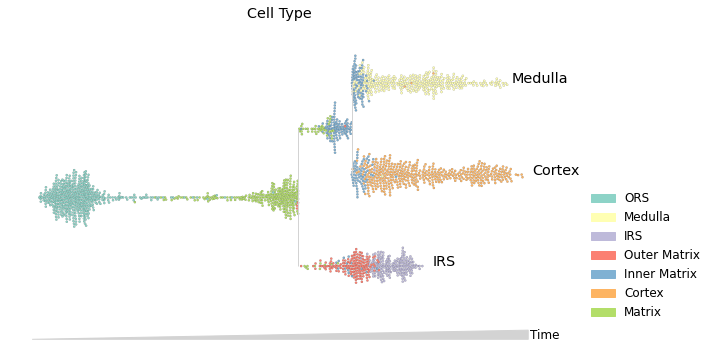

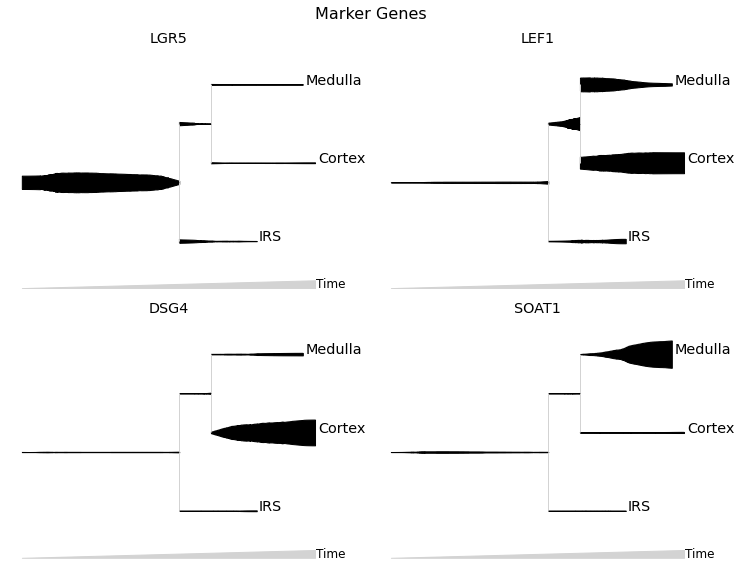

In [14]:
data.obs.true_cell = data.obs.true_cell.astype(str)
mira.pl.plot_stream(data, data = 'true_cell', log_pseudotime=False, max_bar_height=0.99, title = 'Cell Type',
                    figsize=(10,5), style = 'swarm', palette='Set3', size = 5, max_swarm_density = 100)


mira.pl.plot_stream(data, data = ['LGR5','LEF1','DSG4','SOAT1'], 
    log_pseudotime=False, layers = None, plots_per_row = 2,
    clip = 3, window_size=301, scale_features=True, split = True,
    title = 'Marker Genes')
plt.show()

One of the most informative ways to explore pseudotemporal progressions is to visualize the flow of topics through lineages. Plot the flow of expression and accessibility topics side-by-side to compare which modes are driving major changes in cell-type identity:

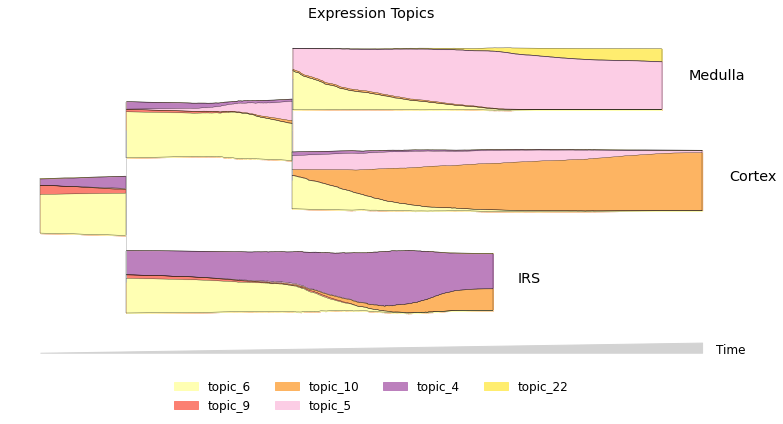

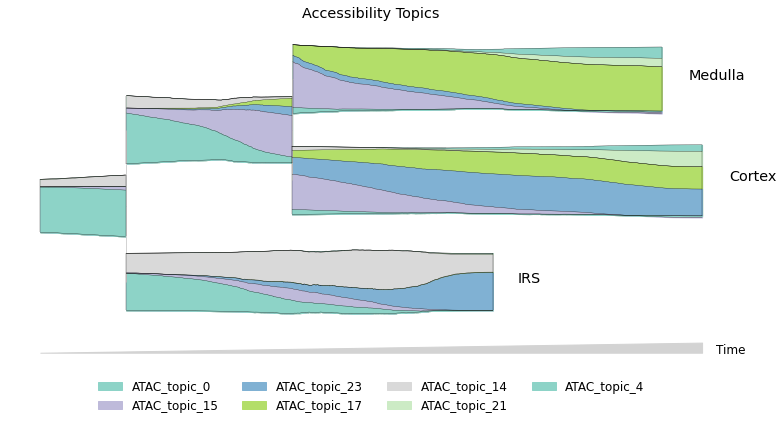

In [15]:
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=4, figsize = (11,6))

mira.pl.plot_stream(data[data.obs.mira_pseudotime > 6.5], 
                    data = ['topic_' + str(i) for i in [6,9,10,5,4,22]], 
                    title = 'Expression Topics',
                    palette=sns.color_palette('Set3')[1::2], # warm tones
                    **plot_kwargs)

mira.pl.plot_stream(data[data.obs.mira_pseudotime > 6.5], 
                    data = ['ATAC_topic_' + str(i) for i in [0, 15, 23, 17, 14, 21, 4]], 
                    title = 'Accessibility Topics',
                    palette=sns.color_palette('Set3')[::2], #+ sns.color_palette('tab20')[::1], # cool tones
                    **plot_kwargs)
plt.show()

**Side note:** We like to use mostly warm tones to describe expression data and cool tones to describe accessibility data. One easy trick to do this with seaborn color palletes is to pass only even-numbered colors from the `Set3` and `Set2` palettes to accessibility streams, and only odd-numbered colors to expression streams.

## Transport map tracing

We can also simulate the differentiation process using [mira.time.trace_differentiation](../time/mira.time.trace_differentiation.html). In this case, we may be interested in finding the ancestral populations of the **IRS** lineage.

This function traces the differentiation process through the diffusion map starting from user-defined start cells, and may be used to investigate complicated lineage structures that may violate the typical assumptions made during lineage inference (no cycles, one path to each termini, terminal states don't regress, etc.)

We can start from a given ``start_lineage`` and work backwards, like below:

INFO:mira.pseudotime.backtrace:Creating transport map ...
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


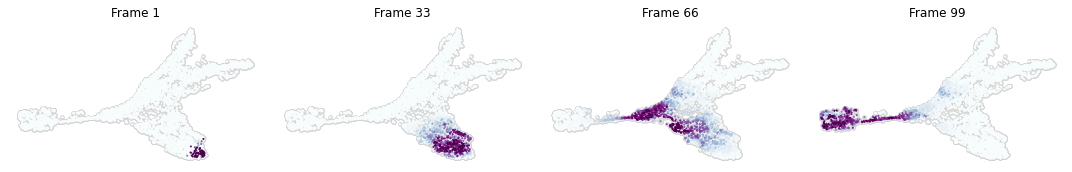

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [16]:
!mkdir -p data
mira.time.trace_differentiation(data, start_lineage='IRS', num_steps=1500,
                               save_name='data/hf_diff.gif', direction='backward', sqrt_time=True,
                               log_prob=True, steps_per_frame=15, figsize=(7,5), ka=3)

The function above makes a video of the process and prints out some preview frames. Then, it saves the video to ``save_name`` as a gif.

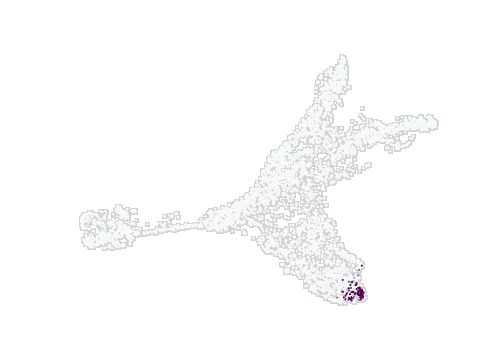

In [17]:
mira.utils.show_gif('data/hf_diff.gif')

We may also run a forward simulation from an interesting group of cells to see their ancestral populations. In this case, we may want to see if the **SSH+ matrix** population can still generate the **IRS** population:

... storing 'true_cell' as categorical


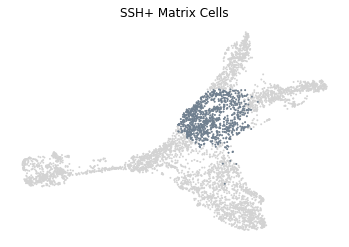

In [18]:
ax = sc.pl.umap(data, show = False, size = 15)
sc.pl.umap(data[data.obs.true_cell == 'Inner Matrix'], na_color = 'slategrey', ax = ax,
          frameon=False, size = 15, title = 'SSH+ Matrix Cells')

INFO:mira.pseudotime.backtrace:Creating transport map ...
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


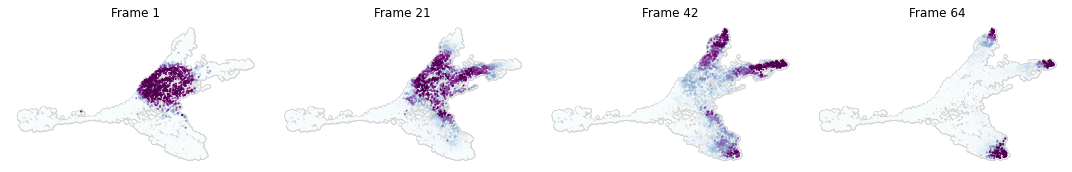

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [19]:
mira.time.trace_differentiation(data,start_cells=data.obs.true_cell.values == 'Inner Matrix', num_steps=1301,
                               save_name='data/hf_diff.gif', direction='forward', sqrt_time=True,
                               log_prob=True, steps_per_frame=20, figsize=(7,5), ka = 3,
                               vmax_quantile=0.97)

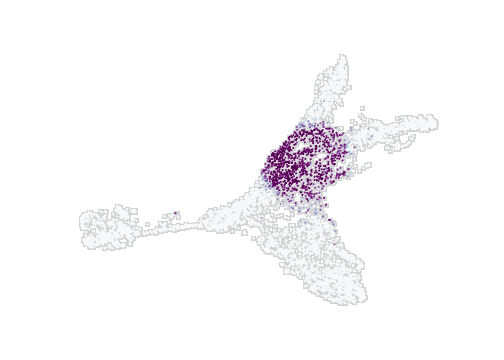

In [20]:
mira.utils.show_gif('data/hf_diff.gif')

Yes! This consistent with experimental lineage tracing evidence that **SSH+ matrix** cells can differentiate into **IRS** cells. This also suggests that the pathway from **SSH-** and **SSH+ matrix** cells to the **IRS** cell type is distinct.

Overall, the parameters needed for pseudotime trajectory inference are:

| Parameter | Source | What it does | Good value |
| -- | -- | -- | -- |
| threshold | MIRA | Controls how far the probability of progressing down one lineage at a branch must diverge from the probability of progressing down another branch before the branch point is assigned. Different topologies demand different thresholds. Try values to find appropriate branch points. | 0.2, 0.5, 1 |
| num diffmap components | MIRA | Number of diffusion map components to use for transport map construction. Determined by eigengap heuristic | determined by eigengap |
| n_neighbors | MIRA | Number of neighbors each cell may transition to in the transport map. | 15, 30 |
| ka | MIRA | Neighborhood size, for adaptive Gaussian kernel, the standard deviation is set as the distance to the *ka*th neighbor | 5 |

Usually, *threshold* is the only parameter that must be adjusted.

Next, one of the most interesting aspects of analyzing multiomics data is constrasting the regulatory dynamics of *cis*-accessibility and gene expression over differentiation timecourses. Of particular interst is when these two related measures of cell state diverge. Please proceed to the next tutorial on **Cis-regulatory modeling**.